In [1]:
import DCDSFunctions as f
import pandas as pd
import pickle
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

In [2]:
h1b1 = pd.read_csv('data/H1B_DataScience_Salaries_V1.csv')

In [11]:
years = list(h1b1.Year.unique())
years

[2014, 2015, 2016, 2017, 2018, 2019]

In [12]:
def slice_by_year(df, year):
    slice_df = df[df['Year'] == year]
    return slice_df

In [14]:
h1b1_2014 = slice_by_year(h1b1, 2014)
h1b1_2015 = slice_by_year(h1b1, 2015)

## 6 ANOVA Assumptions
1. "The dependent variable should be measured at the continuous level (i.e., it is an interval or ratio variable)."
2. "Your three independent variables should each consist of two or more categorical, independent groups"
3. "You should have independence of observations, which means that there is no relationship between the observations in each group or between the groups themselves"
4. "There should be no significant outliers"
5. "Your dependent variable should be approximately normally distributed for each combination of the groups of the three independent variables" (wilkes test)
6. "Homogeneity of variances for each combination of the groups of the three independent variables" Levene's test

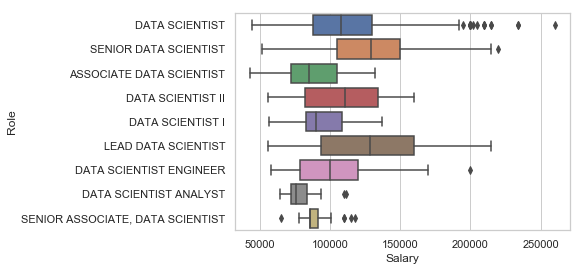

In [13]:
# Let's check the distribution of our dependent variable accross experience levels
sns.set(style="whitegrid")
ax = sns.boxplot(x=slice_by_year(h1b1, 2018)["Salary"], y=slice_by_year(h1b1, 2018)['Role'])

In [ ]:
# ...and across years?
ax = sns.boxplot(x=h1b1["Salary"], y=h1b1['Year'])

In [ ]:
formula = 'Salary ~ C(Role)'
lm = ols(formula, h1b1).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

Would it be a good idea to combine 'Data Scientist' role with 'Senior Data Scientist' (i.e. are they basically the same). Let's run a posthoc test

In [17]:
senior_ds = h1b1[h1b1['Role'] == 'SENIOR DATA SCIENTIST']
senior_ds.head()

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
6002,RENAISSANCE LEARNING INC,"MADISON, WI",SENIOR DATA SCIENTIST,90000,01/05/2015,CERTIFIED,12/22/2014,2014
6003,FPT USA CORPORATION,"EL SEGUNDO, CA",SENIOR DATA SCIENTIST,105000,01/05/2015,CERTIFIED,12/15/2014,2014
6004,NETFLIX INC,"LOS GATOS, CA",SENIOR DATA SCIENTIST,108597,12/13/2014,CERTIFIED,10/09/2014,2014
6005,GENERAL ELECTRIC COMPANY - GE GLOBAL RESEARCH ...,"SAN RAMON, CA",SENIOR DATA SCIENTIST,117500,12/26/2014,CERTIFIED,12/09/2014,2014
6006,LINKEDIN CORPORATION,"MOUNTAIN VIEW, CA",SENIOR DATA SCIENTIST,122096,04/24/2015,CERTIFIED,10/23/2014,2014


In [20]:
just_ds = h1b1[h1b1['Role'] == 'DATA SCIENTIST']
just_ds.head()

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
0,THE MATLEN SILVER GROUP INC,"CHARLOTTE, NC",DATA SCIENTIST,170000,01/05/2015,CERTIFIED,12/12/2014,2014
1,THOUGHTWORKS INC,"CHICAGO, IL",DATA SCIENTIST,71718,09/29/2014,CERTIFIED,09/29/2014,2014
2,EVANTAGE SOLUTIONS INC,"BELLEVUE, WA",DATA SCIENTIST,73923,12/15/2014,CERTIFIED,12/15/2014,2014
3,HOTWIRE INC,"BELLEVUE, WA",DATA SCIENTIST,74755,10/20/2014,CERTIFIED,10/08/2014,2014
4,FINO CONSULTING LLC,"NEW YORK, NY",DATA SCIENTIST,82000,10/20/2014,CERTIFIED,10/16/2014,2014


In [27]:
print(len(senior_ds))
print(len(just_ds))
print(len(senior_ds) + len(just_ds))

1295
6002
7297


In [29]:
senior_and_just_ds = pd.concat([senior_ds, just_ds])
senior_and_just_ds.head()

,Company,Location,Role,Salary,StartDate,Status,SubmitDate,Year
6002,RENAISSANCE LEARNING INC,"MADISON, WI",SENIOR DATA SCIENTIST,90000,01/05/2015,CERTIFIED,12/22/2014,2014
6003,FPT USA CORPORATION,"EL SEGUNDO, CA",SENIOR DATA SCIENTIST,105000,01/05/2015,CERTIFIED,12/15/2014,2014
6004,NETFLIX INC,"LOS GATOS, CA",SENIOR DATA SCIENTIST,108597,12/13/2014,CERTIFIED,10/09/2014,2014
6005,GENERAL ELECTRIC COMPANY - GE GLOBAL RESEARCH ...,"SAN RAMON, CA",SENIOR DATA SCIENTIST,117500,12/26/2014,CERTIFIED,12/09/2014,2014
6006,LINKEDIN CORPORATION,"MOUNTAIN VIEW, CA",SENIOR DATA SCIENTIST,122096,04/24/2015,CERTIFIED,10/23/2014,2014


In [30]:
len(senior_and_just_ds)

7297

In [31]:
formula = 'Salary ~ C(Role)'
lm = ols(formula, senior_and_just_ds).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df           F         PR(>F)
C(Role)   3.850819e+11     1.0  479.282706  5.967086e-103
Residual  5.861201e+12  7295.0         NaN            NaN


...and the answer is no. We should not combine these. What about lead and senior?

In [32]:
lead_ds = h1b1[h1b1['Role'] == 'LEAD DATA SCIENTIST']
len(lead_ds)

246

In [34]:
senior_and_lead_ds = pd.concat([senior_ds, lead_ds])
len(senior_and_lead_ds)

1541

In [35]:
formula = 'Salary ~ C(Role)'
lm = ols(formula, senior_and_lead_ds).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df         F    PR(>F)
C(Role)   4.101983e+09     1.0  4.377729  0.036575
Residual  1.442061e+12  1539.0       NaN       NaN


In [38]:
print(pairwise_tukeyhsd(h1b1.Salary, h1b1.Role, alpha=0.05))

                             Multiple Comparison of Means - Tukey HSD,FWER=0.05                             
             group1                           group2                meandiff     lower       upper    reject
------------------------------------------------------------------------------------------------------------
    ASSOCIATE DATA SCIENTIST              DATA SCIENTIST           21990.556   16026.1172  27954.9948  True 
    ASSOCIATE DATA SCIENTIST          DATA SCIENTIST ANALYST        -4211.45  -14357.8786  5934.9786  False 
    ASSOCIATE DATA SCIENTIST         DATA SCIENTIST ENGINEER       22131.1233  12472.011   31790.2356  True 
    ASSOCIATE DATA SCIENTIST             DATA SCIENTIST I          7151.4527   -1781.4414  16084.3468 False 
    ASSOCIATE DATA SCIENTIST            DATA SCIENTIST II          19977.2305  12347.8121  27606.6489  True 
    ASSOCIATE DATA SCIENTIST           LEAD DATA SCIENTIST         36549.7541  28487.1009  44612.4074  True 
    ASSOCIATE DATA 